### Corollary to Portfolio Optimization: 
#### Monte-Carlo simple case study vs Scipy Optimize constrained Optimization (using SLSQP)

In [20]:
'''

We generated 10,000 random portfolios by assigning random weights to each stock (ensuring they summed to 1). 
For each portfolio, we calculated expected annual return, volatility (from the covariance matrix), and 
Sharpe ratio. We stored all results and identified the portfolio with the highest Sharpe ratio.

We used scipy.optimize.minimize() with the SLSQP algorithm to mathematically maximize the Sharpe ratio by 
minimizing its negative.

    * We passed in mean_returns and cov_matrix as arguments because our objective function (negative_sharpe) 
      needs them to compute return and risk.
    * Constraints ('type': 'eq') and a lambda function ensured that the weights always summed to 1: 
      lambda x: np.sum(x) - 1 == 0.
    * Bounds limited each weight between 0 and 1 — no shorting or leveraging.

'''

# Portfolio Optimization with Monte Carlo Simulation and Scipy Optimization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#### Load and Prepare Data

In [21]:
# 
# Load and Prepare Data
# 

stocklist = ['AMD', 'AAPL', 'MSFT', 'ORCL']
stocks = {}

for stock in stocklist:
    stocks[stock] = pd.read_csv(f"{stock}.csv", index_col='Date', parse_dates=True)

# Create a combined DataFrame of Adjusted Close Prices
adj_close = pd.DataFrame({name: df['Adj Close'] for name, df in stocks.items()})

# Calculate daily returns
stock_returns = adj_close.pct_change().dropna()


#### Define Portfolio Simulation Function (for MonteCarlo)

In [22]:
# 
# Define Portfolio Simulation Function
# 
def simulate_portfolios(returns, num_portfolios=10000, risk_free_rate=0.01):
    np.random.seed(3)
    num_assets = returns.shape[1]
    mean_returns = returns.mean() * 250
    cov_matrix = returns.cov() * 250

    results = {
        'weights': [],
        'returns': [],
        'volatility': [],
        'sharpe': []
    }

    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

        results['weights'].append(weights)
        results['returns'].append(portfolio_return)
        results['volatility'].append(portfolio_volatility)
        results['sharpe'].append(sharpe_ratio)

    return pd.DataFrame(results)

#
# Run Monte Carlo Simulation
#

results_df = simulate_portfolios(stock_returns)

# Identify Optimal Portfolio from Monte Carlo
max_sharpe_idx = results_df['sharpe'].idxmax()
optimal_portfolio_mc = results_df.loc[max_sharpe_idx]

#### Scipy Optimization for Sharpe Ratio

In [23]:
#
# Scipy Optimization for Sharpe Ratio
#
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (ret - risk_free_rate) / vol

num_assets = len(stocklist)
mean_returns = stock_returns.mean() * 250
cov_matrix = stock_returns.cov() * 250
initial_weights = np.array(num_assets * [1. / num_assets])

# Constraints: sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Bounds: each weight between 0 and 1
bounds = tuple((0, 1) for ticker in range(num_assets))

# Run optimization
opt_result = minimize(
    negative_sharpe,
    initial_weights,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights_scipy = opt_result.x
optimal_return = np.dot(optimal_weights_scipy, mean_returns)
optimal_volatility = np.sqrt(np.dot(optimal_weights_scipy.T, np.dot(cov_matrix, optimal_weights_scipy)))
optimal_sharpe = (optimal_return - 0.01) / optimal_volatility


#### Print Summaries and Statistics


Optimal Portfolio from Monte Carlo:
AMD: 29.76%
AAPL: 55.85%
MSFT: 13.32%
ORCL: 1.06%
Sharpe Ratio: 1.7957

Optimal Portfolio from Scipy Optimization:
AMD: 29.82%
AAPL: 55.72%
MSFT: 14.47%
ORCL: 0.00%
Sharpe Ratio: 1.7965


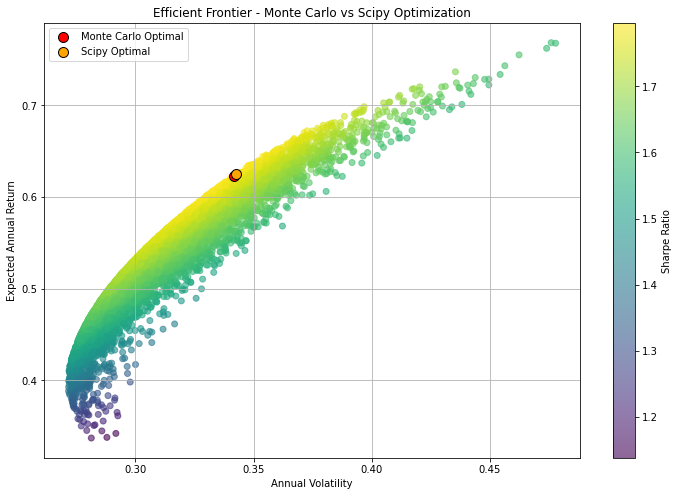

In [25]:
#
#Print Summaries
#

print("\nOptimal Portfolio from Monte Carlo:")
for stock, weight in zip(stocklist, optimal_portfolio_mc['weights']):
    print(f"{stock}: {weight:.2%}")
print(f"Sharpe Ratio: {optimal_portfolio_mc['sharpe']:.4f}")

print("\nOptimal Portfolio from Scipy Optimization:")
for stock, weight in zip(stocklist, optimal_weights_scipy):
    print(f"{stock}: {weight:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.4f}")

#
# 6. Plot Efficient Frontier
#

plt.figure(figsize=(12, 8))
plt.scatter(results_df['volatility'], results_df['returns'], c=results_df['sharpe'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_portfolio_mc['volatility'], optimal_portfolio_mc['returns'], c='red', s=100, edgecolors='black', label='Monte Carlo Optimal')
plt.scatter(optimal_volatility, optimal_return, c='orange', s=100, edgecolors='black', label='Scipy Optimal')
plt.title('Efficient Frontier - Monte Carlo vs Scipy Optimization')
plt.xlabel('Annual Volatility')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.grid(True)
plt.show()